## LSP_EUcrust1.0
Details of the dataset:
- Name: 	LSP_Eucrust1.0
- Title: 	3D shear-wave velocity model for the European crust and uppermost mantle from ambient noise tomography
- Type:	3-D Tomography Earth Model
- Sub Type: 	Shear-wave velocity (km/s)
- Year	2018

Author(s):	
- Yang Lu Institut des Sciences de la Terre (ISTerre), CNRS, Univ. Grenoble Alpes, 1381 Rue de la Piscine, Grenoble, FR
- Laurent Stehly Institut des Sciences de la Terre (ISTerre) , CNRS, Univ. Grenoble Alpes, 1381 Rue de la Piscine, Grenoble, FR
- Anne Paul Institut des Sciences de la Terre (ISTerre), CNRS, Univ. Grenoble Alpes, 1381 Rue de la Piscine, Grenoble, FR
- AlpArray Working Group http://www.alparray.ethz.ch

Reference(s):	
- Yang Lu, Laurent Stehly, Anne Paul, AlpArray Working Group, High-resolution surface wave tomography of the European crust and uppermost mantle from ambient seismic noise, Geophysical Journal International, Volume 214, Issue 2, August 2018, Pages 1136–1150, https://doi.org/10.1093/gji/ggy188

DOI:	doi:10.17611/DP/18250337

Depth Coverage:	0.5 - 79.5 km

Areal Coverage:	Latitude: 34.125 to 65.925 Longitude: -9.975 to 29.925

Model Description
- LSP_Eucrust1.0 is a new high-resolution model for the European crust and uppermost mantle. It contains an isotropic shear-wave velocity model and a probabilistic model (the probability of having an interface at certain depth).

Data Set Description
- The raw data contains up to 4 yr (July 2012–June 2016) of continuous seismic noise recorded by 1293 broad-band stations across Europe (10°W–35°E, 30°N–70°N; see Section 7 of Lu et al. 2018 for more details). The data were obtained through the EIDA (European Integrated Data Archive) data query interface.

Web Page
- [Model Homepage](https://sites.google.com/view/seismology-yanglu)

EMC Page
- [ds.iris.edu/ds/products/emc-lsp_eucrust10/](https://ds.iris.edu/ds/products/emc-lsp_eucrust10/)

## Step0: Downloading & Loading the Source Datasets

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

data_path = "../../../OpenSWI/Datasets/Original/OpenSWI-deep/LSP-Eucrust1.0.nc"

# load the .nc file
data = xr.open_dataset(data_path)

# print the keys of the dataset
print(data.keys())

KeysView(<xarray.Dataset>
Dimensions:                (latitude: 213, longitude: 267, depth: 80)
Coordinates:
  * latitude               (latitude) float32 34.12 34.28 34.42 ... 65.78 65.93
  * longitude              (longitude) float32 -9.975 -9.825 ... 29.77 29.92
  * depth                  (depth) float32 0.5 1.5 2.5 3.5 ... 77.5 78.5 79.5
Data variables:
    vs                     (depth, latitude, longitude) float32 ...
    probability_interface  (depth, latitude, longitude) float32 ...
Attributes: (12/32)
    title:                         A 3D shear wave velocity model for the Eur...
    id:                            LSP_Eucrust1.0
    summary:                       LSP_Eucrust1.0 is a new high-resolution mo...
    keywords:                      seismic, ambient noise tomography, shear w...
    acknowledgment:                Model was provided by Yang Lu, Laurent Ste...
    Conventions:                   CF-1.0
    ...                            ...
    author_institution:      

## Step 1: Velocity Profile Extracting
1. Extracting
2. De-duplicating

In [2]:
latitude = np.array(data['latitude'].values)
longitude = np.array(data['longitude'].values)
depth = np.array(data['depth'].values)
vs = np.array(data['vs'].values)
LON,LAT = np.meshgrid(longitude,latitude)


latitude.shape,longitude.shape,depth.shape,vs.shape

((213,), (267,), (80,), (80, 213, 267))

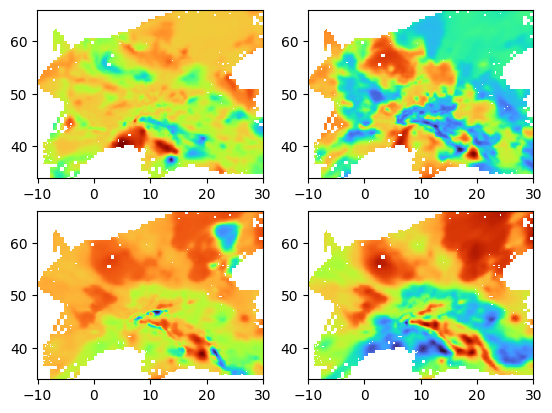

In [3]:
depth_idxs = [10,30,50,70]

fig,axes = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        axes[i][j].pcolormesh(LON,LAT,vs[depth_idxs[i*2+j]],cmap='turbo')
plt.show()

## Step 2: Quality Control & Interpolation

1. interpolation

2. rationalizing (remove the thin layers)


In [ ]:
import sys
sys.path.append('../../../')
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import *

In [5]:
# ------------------------------------------
# Exclude the invalid values
# ------------------------------------------
vs_valid_1d = vs.reshape(vs.shape[0],-1)
vs_valid_mask = np.sum(~np.isnan(vs_valid_1d),axis=0)>0
vs_valid_1d = vs_valid_1d[:,vs_valid_mask]
vs_valid_1d.shape


(80, 43527)

In [6]:
lon_solid = LON.reshape(-1,1)[vs_valid_mask,:]
lat_solid = LAT.reshape(-1,1)[vs_valid_mask,:]
lon_solid.shape

(43527, 1)

In [7]:
vs = vs_valid_1d.T
depth.max()

79.5

In [8]:
# -------------------------------------------------------
#  interp to 1 km thickness
# -------------------------------------------------------
from scipy.interpolate import interp1d

max_depth = 300+0.1
depth_interp = np.concatenate([
    np.arange(0, max_depth, 1)
])
vs_models = vs_interp = np.zeros((vs.shape[0],depth_interp.shape[0]))
for i in range(vs.shape[0]):
    vs_temp = vs[i,:]
    min_depth_idx = np.argmin(np.abs(depth_interp-depth.min()))
    if depth[min_depth_idx] == depth.min():
        min_depth_idx += 1
    max_depth_idx = np.argmin(np.abs(depth_interp-depth.max()))
    depth_interp_temp = depth_interp[min_depth_idx:max_depth_idx]
    f = interp1d(depth.reshape(-1),vs_temp,kind='nearest')
    vs_temp = f(depth_interp_temp)
    vs_interp[i,min_depth_idx:max_depth_idx] = vs_temp
    vs_interp[i,:min_depth_idx] = vs_interp[i,min_depth_idx]
    vs_interp[i,max_depth_idx:] = vs_interp[i,max_depth_idx-1]

vs_interp.shape

(43527, 301)

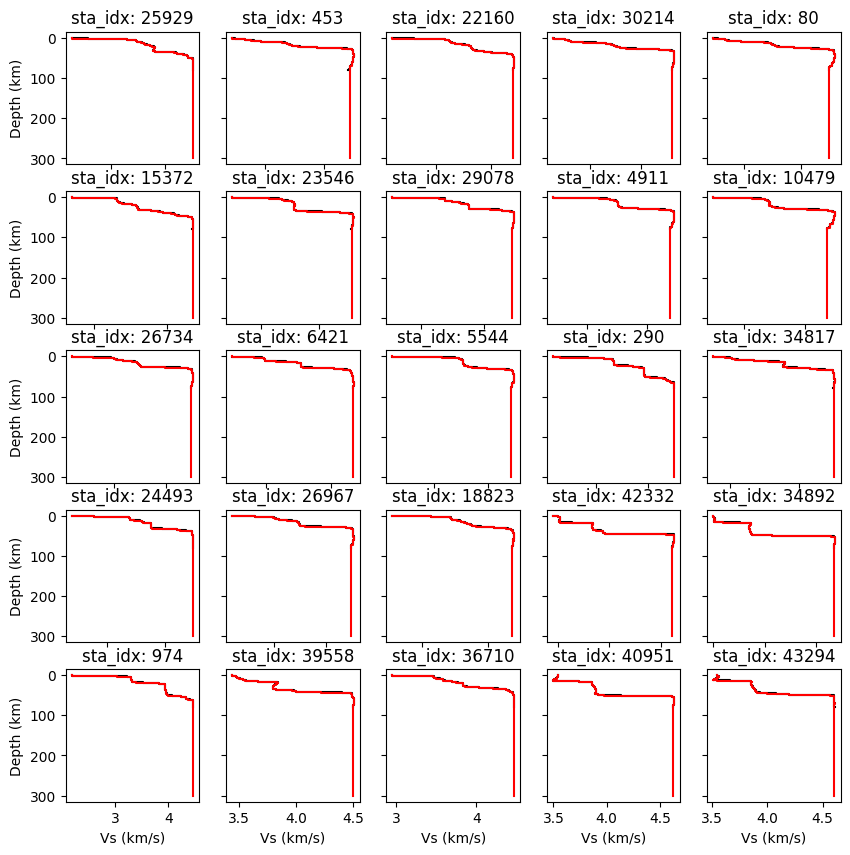

In [9]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs[sta_idx,:],depth,c='k')
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

In [10]:
# -------------------------------------------------------
#  remove the sandwich layers
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(combine_thin_sandwich,
                            vs_interp,
                            list(depth_interp.reshape(1,-1))*len(vs_interp),
                            [6]*len(vs_interp),
                            [1]*len(vs_interp),
                            [0.05]*len(vs_interp),
                            [False]*len(vs_interp))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/43527 [00:00<?, ?it/s]

(43527, 301)

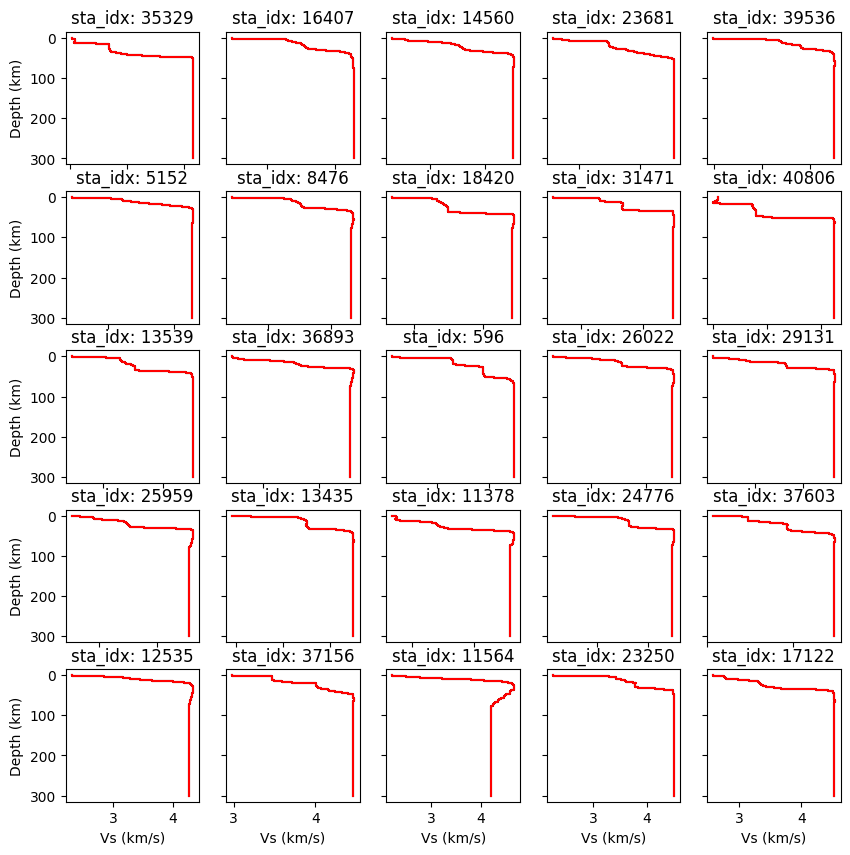

In [11]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='k')
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 3: Dispersion Curve Forward Modeling

In [12]:
vs_models = vs_interp_rm_sandwich.reshape(-1,vs_interp_rm_sandwich.shape[-1]) # [n_models,n_depth]
depth_models = list(depth_interp.reshape(1,-1))*len(vs_models)
vel_models = p_map(transform_vs_to_vel_model,vs_models,depth_models)
vel_models = np.array(vel_models)
vel_models.shape

  0%|          | 0/43527 [00:00<?, ?it/s]

(43527, 301, 4)

In [13]:
# Calculate dispersion curves
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)
vel_models.shape,disp_data.shape

  0%|          | 0/43527 [00:00<?, ?it/s]

((43527, 301, 4), (43527, 300, 3))

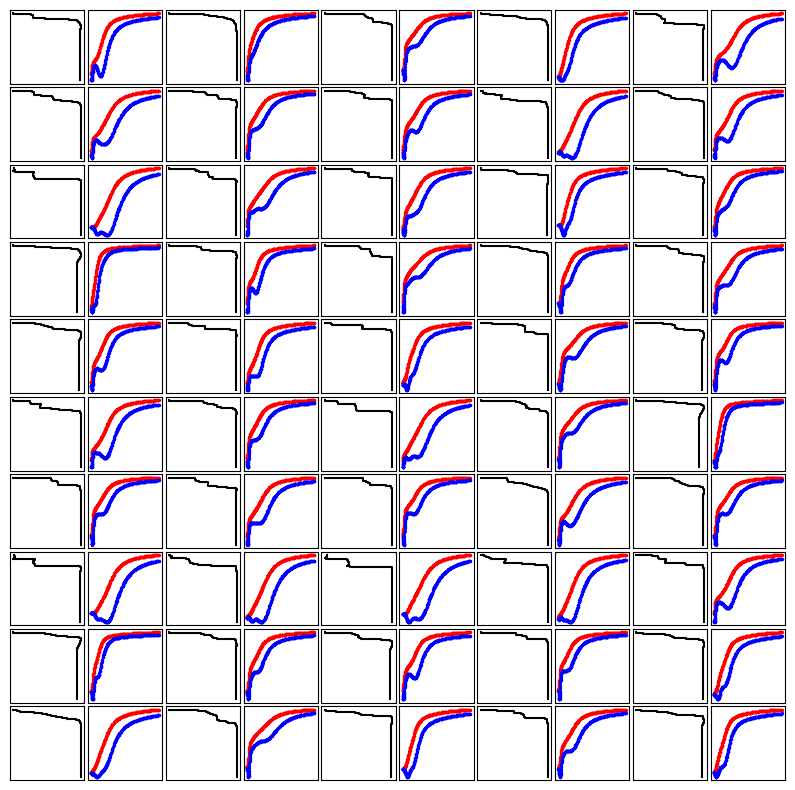

In [14]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='k')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

In [15]:
phase_mask = np.sum(disp_data[:,:,1] == 0,axis=1)==0
group_mask = np.sum(disp_data[:,:,2] == 0,axis=1)==0
mask = phase_mask*group_mask

lon_solid = LON.reshape(-1,1)[vs_valid_mask,:]
lat_solid = LAT.reshape(-1,1)[vs_valid_mask,:]
loc = np.hstack((lon_solid,lat_solid))[mask,:]
vel_models = vel_models[mask,:,:]
disp_data = disp_data[mask,:,:]

In [ ]:
import os
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-deep/1s-100s-Base"
# Save processed data as compressed npz files
np.savez_compressed(os.path.join(save_base_path, "EUCrust_loc.npz"),
                    data=loc.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "EUCrust_model.npz"),
                    data=vel_models.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "EUCrust_disp.npz"),
                    data=disp_data.astype(np.float32))